In [15]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [16]:
# Loading the cleaned dataset, in which within-mouse outliers have been removed and then the MEDIAN per mouse has been calculated
# Outlier biological replicates are still present.  Some mice are missing data for some proteins.
# (8/76 proteins are missing at least one data point.)
data = pd.read_csv('Data_Cortex_Nuclear_Medians_Clean.csv')
data.replace(to_replace={'C/S': 'Learning', 'S/C': 'Control'}, inplace=True)
data.head()

,Genotype,Behavior,Treatment,class,Mouse,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,...,pGSK3B_Tyr216_N,SHH_N,BAD_N,BCL2_N,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N
0,Control,Learning,Memantine,c-CS-m,309,0.416923,0.564036,0.355124,2.260135,4.268735,...,0.833277,0.191561,0.141013,NaN,0.111483,0.434154,0.130405,0.155612,0.158235,1.675652
1,Control,Learning,Memantine,c-CS-m,311,0.591572,0.690271,0.320853,2.285938,4.229412,...,0.679241,0.181889,0.167400,0.168637,NaN,0.430309,0.147208,0.215089,0.197067,1.219966
2,Control,Learning,Memantine,c-CS-m,320,0.530855,0.748072,0.385529,2.606780,5.601210,...,0.854093,0.220316,0.161053,0.136110,0.123425,0.534845,0.143169,0.180373,NaN,1.638988
3,Control,Learning,Memantine,c-CS-m,321,0.420542,0.640420,0.357512,2.731909,5.468987,...,0.922769,0.234360,NaN,0.160967,NaN,0.561673,0.152119,0.214380,NaN,1.682427
4,Control,Learning,Memantine,c-CS-m,322,0.356514,0.500887,0.316709,2.062867,4.128476,...,0.829548,0.239625,NaN,0.150934,0.140960,0.494885,NaN,NaN,NaN,1.614975


In [17]:
# identify which columns represent protein names
not_a_protein = ['Genotype','Behavior','Treatment','class', 'Mouse']
protein_names = data.columns[5:]
X_columns = data[protein_names]
medians = X_columns.median()
X_imputed = X_columns.fillna(medians)
y = data['class']

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble        import RandomForestClassifier
from sklearn.ensemble        import GradientBoostingClassifier
from sklearn.metrics         import precision_recall_curve

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, 
                                                    test_size = 0.2, stratify = y)

In [45]:
classifier_rf = RandomForestClassifier(criterion = 'gini', max_features = 'sqrt', n_estimators = 1000, 
                                       max_depth = None, n_jobs = -1, min_samples_leaf = 1)
classifier_rf.fit(X_train, y_train)
training_accuracy = classifier_rf.score(X_train, y_train)
test_accuracy = classifier_rf.score(X_test, y_test)
print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 1.000000
Accuracy on test data:     0.600000


In [46]:
importance_df = pd.DataFrame({'protein': X_columns.columns, 
                              'importance': classifier_rf.feature_importances_})
importance_df.sort_values('importance', ascending = False).head(10)

,protein,importance
32,SOD1_N,0.042282
75,CaNA_N,0.036076
30,APP_N,0.030962
19,AKT_N,0.029304
34,P38_N,0.028256
53,ARC_N_pS6_N,0.027734
1,ITSN1_N,0.026261
48,S6_N,0.022904
10,pERK_N,0.022480
55,nNOS_N,0.022295


In [47]:
classifier_gb = GradientBoostingClassifier()
classifier_gb.fit(X_train, y_train)
training_accuracy = classifier_gb.score(X_train, y_train)
test_accuracy = classifier_gb.score(X_test, y_test)
print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 1.000000
Accuracy on test data:     0.466667


In [48]:
importance_df = pd.DataFrame({'protein': X_columns.columns, 
                              'importance': classifier_gb.feature_importances_})
importance_df.sort_values('importance', ascending = False).head(10)

,protein,importance
34,P38_N,0.093183
19,AKT_N,0.080210
15,pNR2A_N,0.067286
35,pMTOR_N,0.062870
30,APP_N,0.060504
72,H3AcK18_N,0.060118
33,MTOR_N,0.055415
46,pPKCG_N,0.054192
55,nNOS_N,0.049421
32,SOD1_N,0.045300


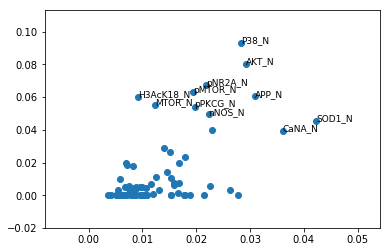

In [49]:
_ = plt.scatter(classifier_rf.feature_importances_, classifier_gb.feature_importances_)
for i,txt in enumerate(X_columns.columns):
    x_pt = classifier_rf.feature_importances_[i]
    y_pt = classifier_gb.feature_importances_[i]
    if (x_pt > 0.03) or (y_pt > 0.04):
        plt.text(x_pt, y_pt, txt, fontsize=9)

In [25]:
raw_data = pd.read_excel('Data_Cortex_Nuclear.xls')
data_full = raw_data.join(pd.DataFrame(list(raw_data['MouseID'].str.split('_')),columns = ['Mouse','Rep']))
data_full.drop('pS6_N',axis=1, inplace=True)
data_full.rename(columns={'ARC_N': 'ARC_N_pS6_N'}, inplace=True)

In [50]:
y_test.shape

(15,)

In [51]:
X_train.shape

(57, 76)

In [27]:
data.groupby('class').count()['Mouse']

class
c-CS-m    10
c-CS-s     9
c-SC-m    10
c-SC-s     9
t-CS-m     9
t-CS-s     7
t-SC-m     9
t-SC-s     9
Name: Mouse, dtype: int64

In [ ]:
y_3_1 = data.class
y_2_1 = 